In [2]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [330]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.wkb import loads
from library.lib_aws import PostgresRDS
from library import lib_dyna
import matplotlib.pyplot as plt
import seaborn as sns
from pyefd import reconstruct_contour

## Data Selection

Data is selected for Well **Cook 12-13 6B** between the Dates **2019-03-19** and **2020-05-26**.

Following Columns are selected:
- NodeID
- Date
- pocdowncard

After querying `pocdowncard` is in a WKB format. This will be converted to a Shapely Polygon Object using the `shapely.wkb.loads` method

In [111]:
query = """
SELECT 
    "NodeID",
    "Date",
    "pocdowncard",
    "Fillage",
    "SPM"
FROM
    xspoc.card
WHERE
    "NodeID" = 'Cook 12-13 6B' AND
    "Date" BETWEEN '2019-03-19' AND '2020-05-26'
"""

with PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    
print("\nData before converting")
data.dropna(inpalce=True)  # Nans arent present, but if they are will have to be dropped
display(data.head())

# COnverting the card data
data.pocdowncard = data.pocdowncard.apply(lambda x: loads(x, hex=True))
print("Data after converting")
display(data.head())

Connected to oasis-dev DataBase
Connection Closed

Data before converting


,NodeID,Date,pocdowncard,Fillage,SPM
0,Cook 12-13 6B,2019-03-19 00:12:48,010300000001000000640000000000008014AE16400000...,94.8,3.1
1,Cook 12-13 6B,2019-03-19 00:55:33,01030000000100000064000000000000608FC219400000...,44.9,1.4
2,Cook 12-13 6B,2019-03-19 02:52:18,0103000000010000006400000000000060B81E05400000...,49.4,1.4
3,Cook 12-13 6B,2019-03-19 03:09:29,0103000000010000006400000000000040E17A14400000...,98.4,3.1
4,Cook 12-13 6B,2019-03-19 04:20:22,01030000000100000064000000000000C0CCCC0E400000...,52.8,1.4


Data after converting


,NodeID,Date,pocdowncard,Fillage,SPM
0,Cook 12-13 6B,2019-03-19 00:12:48,"POLYGON ((5.670000076293945 -9814, 15.43000030...",94.8,3.1
1,Cook 12-13 6B,2019-03-19 00:55:33,"POLYGON ((6.440000057220459 -8749, 15.72000026...",44.9,1.4
2,Cook 12-13 6B,2019-03-19 02:52:18,"POLYGON ((2.640000104904175 -9096, 10.68999958...",49.4,1.4
3,Cook 12-13 6B,2019-03-19 03:09:29,"POLYGON ((5.119999885559082 -10034, 14.3500003...",98.4,3.1
4,Cook 12-13 6B,2019-03-19 04:20:22,"POLYGON ((3.849999904632568 -9043, 13.32999992...",52.8,1.4


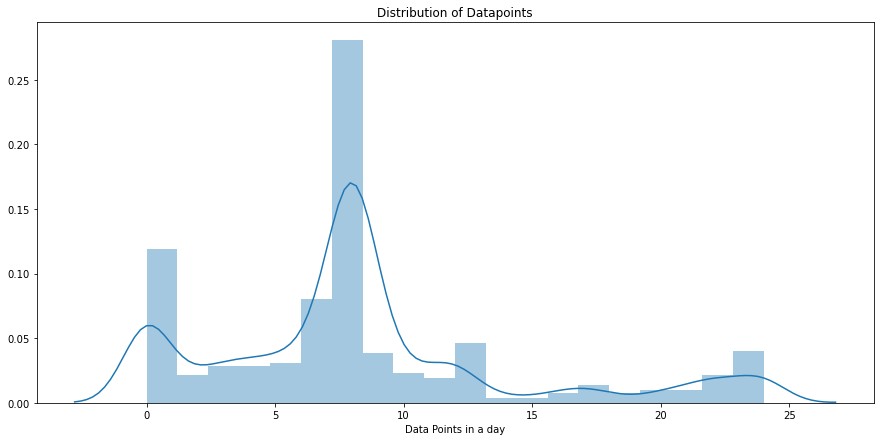

In [112]:
"""
Identifying Number of Cards Present in a Day
"""
grouper = data.set_index('Date').groupby(pd.Grouper(freq='1D'))
grp = grouper['pocdowncard'].count()

plt.figure(figsize=(15, 7)) 
sns.distplot(grp.values, bins=20)
plt.xlabel('Data Points in a day')
plt.title("Distribution of Datapoints")
plt.show()

In [260]:
print("Time Differnece Between cards")
data.Date.diff().apply(lambda t: t.round(freq='H')).dropna().value_counts()

Time Differnece Between cards


0 days 03:00:00     1568
0 days 02:00:00      835
0 days 00:00:00      565
0 days 01:00:00      426
0 days 04:00:00       59
0 days 06:00:00       51
0 days 05:00:00       14
0 days 08:00:00       14
0 days 09:00:00       11
1 days 03:00:00       10
0 days 10:00:00        9
0 days 07:00:00        8
0 days 12:00:00        7
0 days 18:00:00        5
1 days 02:00:00        4
0 days 16:00:00        4
0 days 15:00:00        3
1 days 01:00:00        2
1 days 09:00:00        2
0 days 21:00:00        2
1 days 04:00:00        2
1 days 16:00:00        1
39 days 22:00:00       1
3 days 07:00:00        1
0 days 11:00:00        1
7 days 00:00:00        1
1 days 05:00:00        1
0 days 22:00:00        1
0 days 13:00:00        1
0 days 14:00:00        1
1 days 20:00:00        1
1 days 22:00:00        1
2 days 18:00:00        1
1 days 23:00:00        1
4 days 00:00:00        1
1 days 00:00:00        1
Name: Date, dtype: int64

### Generating Features for forecasting

**Logic Used:**

**Variables:** 

window --> No of timestamps used for forecasting

n -->  No of timesteps forecasted

delta --> Time Delta within which the window and n at a minimum shoul lie. This accounts for variable frequencies of cards in a specific day

*Note: Using a delta like this will not completely account for the varibale time differnece between cards.* 

*Once the frequecy between cards is constant, time-delta can be a function of window and n*

**Steps**
- Iterate over each index (Timestamp)
- For a specicif t (timestamp), identify the values lying within a delta (t + delta) 
- Check if atleast a minimum of (window + n) no of samples lie in this time chunk.
- If it does:
    - Append the xt and the yt values
    - xt will be all the features between t and window
    - yt will be all features betweent winow and n
- If does not meet the requirements dont consider those features.


In [270]:
def forecast_features(ts, window, n, delta):
    """
    Creates a forecasting matirx of X and Y
    The shape of X is no_of_samples * window * Number of features
    The shape of y is no_of_samples * timesteps_forecasted * Number of features
    :param ts: TImesereies being forecasted. Timestamps as the index and features as the columns
    :param window: The window for prediction (No of timesteps to use for predictions)
    :param n: The number of timesteps forecasted
    :param delta: The time delta used for selecting continuous timesteps
    """
    
    X = []  # Initialize feature Matrix
    y = []  # Initialize labels
    c = 0  # Counter to see how many data points were dropped
    delta = pd.Timedelta(delta)
    for t in ts.index:
        time_chunk = ts[t: t+delta]  # Get the chunk of time from the time delta
        if time_chunk.shape[0] >= (window + n):  # Need to have atleast window + n of data points in the time chunk
            X.append(time_chunk.iloc[0: window].values)
            y.append(time_chunk.iloc[window: window+n].values)
        else:
            c+=1

    print("No. of datapoints discarded {}".format(c))
    X = np.array(X)
    y = np.array(y)
    
    return X, y
    

In [266]:
"""
Testing the  fucntion
Using SPM And Fillage as features to be forecasted
Can have FD as well
"""
ts = data.set_index('Date')[['Fillage', 'SPM']]

print("Timeseries data with shape {}".format(ts.shape[0]))
display(ts.head())

Timeseries data with shape 3617


,Fillage,SPM
Date,,
2019-03-19 00:12:48,94.8,3.1
2019-03-19 00:55:33,44.9,1.4
2019-03-19 02:52:18,49.4,1.4
2019-03-19 03:09:29,98.4,3.1
2019-03-19 04:20:22,52.8,1.4


In [283]:
x_fore, y_fore = forecast_features(ts=ts, window=5, n=1, delta='16H')

No of datapoints discarded 411


In [284]:
print("Shape of x")
print(np.shape(x_fore))

print("\nShape of y")
print(np.shape(y_fore))

Shape of x
(3206, 5, 2)

Shape of y
(3206, 1, 2)


### Getting FD matrix 

In [285]:
data.head()

,NodeID,Date,pocdowncard,Fillage,SPM
0,Cook 12-13 6B,2019-03-19 00:12:48,"POLYGON ((5.670000076293945 -9814, 15.43000030...",94.8,3.1
1,Cook 12-13 6B,2019-03-19 00:55:33,"POLYGON ((6.440000057220459 -8749, 15.72000026...",44.9,1.4
2,Cook 12-13 6B,2019-03-19 02:52:18,"POLYGON ((2.640000104904175 -9096, 10.68999958...",49.4,1.4
3,Cook 12-13 6B,2019-03-19 03:09:29,"POLYGON ((5.119999885559082 -10034, 14.3500003...",98.4,3.1
4,Cook 12-13 6B,2019-03-19 04:20:22,"POLYGON ((3.849999904632568 -9043, 13.32999992...",52.8,1.4


In [429]:
"""
Method 1
Using the Features Class in lib_dyna
Will have to convert it back into a dataframe with Date as the index
"""

fea = lib_dyna.Features(df=data,
                        well_col='NodeID',
                       card_col='pocdowncard')

In [430]:
fea.remove_errors()  # Removes all data points where fd cant be found
bounds = fea.all_bounds()  # Can be used to normalize in a well specific min-max
# clean_df = fea.df  # If shape is same as data dont have to run remove errors
fd = fea.get_X(fd_order=5, area=False, centroid=False, normalize_fn='card')

if fd.shape[0] != data.shape[0]:
    data = fea.df  # some data points were removed as errors, we need clean data as data

fd_df = pd.DataFrame(index = data.Date, data = fd)

fd_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2019-03-19 00:12:48,-0.402040,0.361361,-0.373959,-0.364688,0.002614,-0.012534,-0.007935,0.013022,-0.038611,-0.033921,-0.051655,0.044632,-0.000421,-0.000852,0.000163,-0.004354,-0.014520,0.016863,-0.017728,-0.017844
2019-03-19 00:55:33,-0.377050,0.216561,-0.432135,-0.226772,0.088966,0.019861,-0.079876,-0.045497,-0.061895,0.029665,-0.003036,-0.010387,-0.020631,-0.017995,0.017447,-0.000450,-0.012503,0.009455,-0.016020,-0.005684
2019-03-19 02:52:18,-0.375761,0.228110,-0.437984,-0.231314,0.085119,0.024245,-0.071931,-0.042930,-0.068070,0.024600,-0.001941,-0.005291,-0.022018,-0.022513,0.016399,0.005315,-0.011830,0.007522,-0.017609,-0.002832
2019-03-19 03:09:29,-0.408550,0.366354,-0.369159,-0.370541,-0.000543,-0.017494,-0.009474,0.017573,-0.032757,-0.036109,-0.053253,0.042040,-0.001324,0.002759,0.000690,-0.005348,-0.016671,0.014858,-0.016587,-0.017804
2019-03-19 04:20:22,-0.371793,0.231835,-0.432968,-0.252380,0.083193,0.032011,-0.072132,-0.048730,-0.076527,0.020529,0.001947,-0.001026,-0.019984,-0.025626,0.016466,0.007854,-0.008610,0.008182,-0.020283,-0.006261


In [431]:
"""
Generating features for forecasting
"""

x_fore, y_fore = forecast_features(ts=fd_df, window=5, n=1, delta='16H')  # 5 timesteps to predict the next in a 16H delta

print("Shape of x")
print(np.shape(x_fore))

print("\nShape of y")
print(np.shape(y_fore))

No of datapoints discarded 411
Shape of x
(3206, 5, 20)

Shape of y
(3206, 1, 20)


## LSTM

Using the test LSTM from the code `LSTM - Oasis`. To see if the feature matrix dimensions are correct

In [432]:
# Keras Functions
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [435]:
fd_order = 5

In [436]:
# Dividing Input (X) to train, validation and test sets
trainX      = x_fore[0:2800]
validationX = x_fore[2800:3000]
testX       = x_fore[3000:3206]

# Dividing Output (y_fore) to train, validation and test sets
# Using reshape as the model built is for a single time forecast
trainY      = y_fore.reshape(3206, fd_order*4)[0:2800]
validationY = y_fore.reshape(3206, fd_order*4)[2800:3000]
testY       = y_fore.reshape(3206, fd_order*4)[3000:3206]

In [437]:
# defining the LSTM model

model = Sequential()
model.add(LSTM(200, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True, activation = 'relu'))
model.add(LSTM(100, activation = 'relu'))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy'])

In [438]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 5, 200)            176800    
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2020      
Total params: 299,220
Trainable params: 299,220
Non-trainable params: 0
_________________________________________________________________


In [439]:
# Fit the LSTM Model
model.fit(trainX, trainY, 
          epochs=20, 
          batch_size=1,  validation_data=(validationX,validationY))

Epoch 1/20
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0011 - mse: 0.0011 - accuracy: 0.9936 - val_loss: 7.2917e-04 - val_mse: 7.2917e-04 - val_accuracy: 1.0000
Epoch 2/20
2800/2800 [==============================] - 9s 3ms/step - loss: 9.2143e-04 - mse: 9.2143e-04 - accuracy: 0.9971 - val_loss: 6.1831e-04 - val_mse: 6.1831e-04 - val_accuracy: 1.0000
Epoch 3/20
2800/2800 [==============================] - 8s 3ms/step - loss: 8.7318e-04 - mse: 8.7318e-04 - accuracy: 0.9971 - val_loss: 6.6256e-04 - val_mse: 6.6256e-04 - val_accuracy: 1.0000
Epoch 4/20
2800/2800 [==============================] - 8s 3ms/step - loss: 8.6554e-04 - mse: 8.6554e-04 - accuracy: 0.9971 - val_loss: 6.0742e-04 - val_mse: 6.0742e-04 - val_accuracy: 1.0000
Epoch 5/20
2800/2800 [==============================] - 9s 3ms/step - loss: 8.5110e-04 - mse: 8.5110e-04 - accuracy: 0.9971 - val_loss: 5.8476e-04 - val_mse: 5.8476e-04 - val_accuracy: 1.0000
Epoch 6/20
2800/2800 [==========================

In [440]:
accr_test = model.evaluate(testX,testY)
print('Test set\n  Loss: {:0.3f}\n  mae: {:0.3f}, \n  Accuracy: {:0.3f}'.format(accr_test[0],
                                                                                accr_test[1],
                                                                                accr_test[2]))

accr_train = model.evaluate(trainX,trainY)
print('Train set\n  Loss: {:0.3f}\n  mae: {:0.3f}, \n  Accuracy: {:0.3f}'.format(accr_train[0],
                                                                                 accr_train[1],
                                                                                 accr_train[2]))

7/7 [==============================] - 0s 3ms/step - loss: 6.0084e-04 - mse: 6.0084e-04 - accuracy: 1.0000
Test set
  Loss: 0.001
  mae: 0.001, 
  Accuracy: 1.000
88/88 [==============================] - 0s 3ms/step - loss: 6.5431e-04 - mse: 6.5431e-04 - accuracy: 0.9971
Train set
  Loss: 0.001
  mae: 0.001, 
  Accuracy: 0.997


In [441]:
"""
Predcitions
"""
ypred = model.predict(testX)
ypred_df = pd.DataFrame(ypred)  # predicted DF
ytrue_df = pd.DataFrame(testY)  # True df

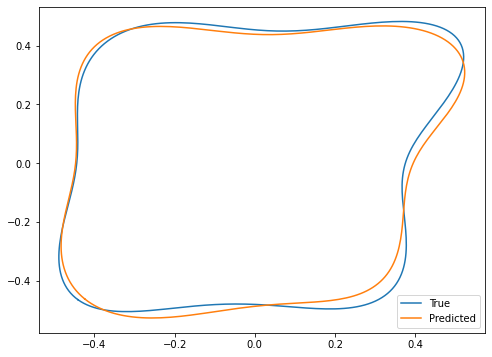

In [444]:
"""
PLotting
"""
index = 45

fd_true = ytrue_df.loc[index].values.reshape(fd_order,4)
fd_pred = ypred_df.loc[index].values.reshape(fd_order,4)

true_xy = reconstruct_contour(fd_true)
pred_xy = reconstruct_contour(fd_pred)

plt.figure(figsize=(8,6))
plt.plot(true_xy[:,0], true_xy[:,1], label='True')
plt.plot(pred_xy[:,0], pred_xy[:,1], label='Predicted')
plt.legend()
plt.show()